In [2]:
# Imports (for Graphs + Analysis)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tabulate import tabulate

sns.set_theme(style='ticks', context='paper')

In [3]:
# Constants
ENERGY_CONSUMPTION = "Energy Consumption (exc. PUE)"
ENERGY_CONSUMPTION_PUE = "Energy Consumption (inc. PUE)"
MEMORY_CONSUMPTION = "Memory Energy Consumption (exc. PUE)"
MEMORY_CONSUMPTION_PUE = "Memory Energy Consumption (inc. PUE)"
CARBON_EMISSIONS = "Carbon Emissions"

In [148]:
# Trace File Paths List
workflows = ['chipseq', 'mag', 'montage', 'nanoseq', 'rangeland', 'rnaseq', 'sarek']
regions = ['Great Britain', 'Germany', 'California', 'Texas', 'South Africa', 'Tokyo', 'New South Wales']
short_regions = ['gb', 'de', 'ca', 'tx', 'zaf', 'tyo', 'nsw']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
short_months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'] 
month_dates = ['08012024-13012024', '12022024-17022024', '11032024-16032024',  
    '08042024-13042024', '13052024-18052024', '10062024-15062024',  
    '08072024-13072024', '12082024-17082024', '09092024-14092024',  
    '14102024-19102024', '11112024-16112024', '09122024-14122024']
region_folders = [f'../data/results/interrupt-wf-shifting/out/{region}/' for region in short_regions]
windows = [6, 12, 24, 48, 96]

In [5]:
def get_max_overhead(overheads):
    oh_1, _ = overheads[0].split('|')
    oh_2, _ = overheads[1].split('|')
    oh_3, _ = overheads[2].split('|')

    return max([float(oh_1), float(oh_2), float(oh_3)])
    

def parse_ts_summary_file(file):
    with open(file, 'r') as f:
        lines = f.readlines()[1:]

    props = {}

    for line in lines:
        parts = line.split(',')
        workflow = parts[0].split('-')[0]
        footprint = float(parts[1])
        makespan = float(parts[2])
        entry_6h = parts[3].split(':')
        entry_12h = parts[4].split(':')
        entry_24h = parts[5].split(':')
        entry_48h = parts[6].split(':')
        entry_96h = parts[7].split(':')

        if len(props) == 0:
            props = {
                "FOOTPRINT": [footprint],
                "MAKESPAN": [makespan],
                "6H_FOOTPRINT": [float(entry_6h[1])],
                "6H_REDUCTION": [float(entry_6h[0][:-1])],
                "6H_OVERHEAD": [entry_6h[2]],
                "12H_FOOTPRINT": [float(entry_12h[1])],
                "12H_REDUCTION": [float(entry_12h[0][:-1])],
                "12H_OVERHEAD": [entry_12h[2]],
                "24H_FOOTPRINT": [float(entry_24h[1])],
                "24H_REDUCTION": [float(entry_24h[0][:-1])],
                "24H_OVERHEAD": [entry_24h[2]],
                "48H_FOOTPRINT": [float(entry_48h[1])],
                "48H_REDUCTION": [float(entry_48h[0][:-1])],
                "48H_OVERHEAD": [entry_48h[2]],
                "96H_FOOTPRINT": [float(entry_96h[1])],
                "96H_REDUCTION": [float(entry_96h[0][:-1])],
                "96H_OVERHEAD": [entry_96h[2]]
            }
        else: 
            props["FOOTPRINT"].append(footprint)
            props["MAKESPAN"].append(makespan)
            props["6H_FOOTPRINT"].append(float(entry_6h[1]))
            props["6H_REDUCTION"].append(float(entry_6h[0][:-1]))
            props["6H_OVERHEAD"].append(entry_6h[2])
            props["12H_FOOTPRINT"].append(float(entry_12h[1]))
            props["12H_REDUCTION"].append(float(entry_12h[0][:-1]))
            props["12H_OVERHEAD"].append(entry_12h[2])
            props["24H_FOOTPRINT"].append(float(entry_24h[1]))
            props["24H_REDUCTION"].append(float(entry_24h[0][:-1]))
            props["24H_OVERHEAD"].append(entry_24h[2])
            props["48H_FOOTPRINT"].append(float(entry_48h[1]))
            props["48H_REDUCTION"].append(float(entry_48h[0][:-1]))
            props["48H_OVERHEAD"].append(entry_48h[2])
            props["96H_FOOTPRINT"].append(float(entry_96h[1]))
            props["96H_REDUCTION"].append(float(entry_96h[0][:-1]))
            props["96H_OVERHEAD"].append(entry_96h[2])

    data = {}
    wf_makespan = sum(props["MAKESPAN"]) / 3
    footprint_6h = sum(props["6H_FOOTPRINT"]) / 3
    reduction_6h = sum(props["6H_REDUCTION"]) / 3
    max_overhead_6h = get_max_overhead(props["6H_OVERHEAD"])
    footprint_12h = sum(props["12H_FOOTPRINT"]) / 3
    reduction_12h = sum(props["12H_REDUCTION"]) / 3

    if reduction_12h < reduction_6h:
        reduction_12h = reduction_6h

    max_overhead_12h = get_max_overhead(props["12H_OVERHEAD"])
    footprint_24h = sum(props["24H_FOOTPRINT"]) / 3
    reduction_24h = sum(props["24H_REDUCTION"]) / 3

    if reduction_24h < reduction_12h:
        reduction_24h = reduction_12h

    max_overhead_24h = get_max_overhead(props["24H_OVERHEAD"])
    footprint_48h = sum(props["48H_FOOTPRINT"]) / 3
    reduction_48h = sum(props["48H_REDUCTION"]) / 3

    if reduction_48h < reduction_24h:
        reduction_48h = reduction_24h

    max_overhead_48h = get_max_overhead(props["48H_OVERHEAD"])
    footprint_96h = sum(props["96H_FOOTPRINT"]) / 3
    reduction_96h = sum(props["96H_REDUCTION"]) / 3

    if reduction_96h < reduction_48h:
        reduction_96h = reduction_48h

    max_overhead_96h = get_max_overhead(props["6H_OVERHEAD"])

    data = {
        "FOOTPRINT": sum(props["FOOTPRINT"]) / 3,
        "MAKESPAN": wf_makespan,
        "6H_REDUCTION": reduction_6h,
        "6H_OVERHEAD":  max_overhead_6h,
        "12H_REDUCTION":  reduction_12h,
        "12H_OVERHEAD":  max_overhead_12h,
        "24H_REDUCTION":  reduction_24h,
        "24H_OVERHEAD":  max_overhead_24h,
        "48H_REDUCTION":  reduction_48h,
        "48H_OVERHEAD":  max_overhead_48h,
        "96H_REDUCTION":  reduction_96h,
        "96H_OVERHEAD":  max_overhead_96h
    }

    return data
        

In [6]:
def write_to_file(outfile, data, headers):
    with open(f'../data/results/interrupt-wf-shifting/out/{outfile}', 'w') as f:
        f.write(','.join(headers) + '\n')

        for row in data:
            f.write(','.join(row) + '\n')

In [7]:
# Compare with Entire workflow shifting


In [109]:
# Interrupting Footprints - Average CI
headers = ["Region", "Month", "Workflow", "Original Footprint (gCO2e)", "Makespan (s)", "Reduction 6h (%)", "Overhead", "Reduction 12h (%)", "Overhead", "Reduction 24h (%)", "Overhead", "Reduction 48h (%)", "Overhead", "Reduction 96h (%)","Overhead"]
data_avg_tbl = []
data_avg_dct = {}

for region, region_base in zip(short_regions, region_folders):
    if region not in data_avg_dct:
        data_avg_dct[region] = {}
    for month in short_months:
        for workflow in workflows:
            if workflow not in data_avg_dct[region]:
                data_avg_dct[region][workflow] = {}
            if month not in data_avg_dct[region][workflow]:
                data_avg_dct[region][workflow][month] = {} 
            temp = parse_ts_summary_file(f'{region_base}{workflow}-{month}-avg-ts.csv')
            span = temp["MAKESPAN"]
            data_avg_tbl.append([region, month, workflow,f'{temp["FOOTPRINT"]:.2f}', f'{span:.0f}', 
                 f"{temp['6H_REDUCTION']:.2f}", f"{temp['6H_OVERHEAD']:.2f}", 
                 f"{temp['12H_REDUCTION']:.2f}", f"{temp['12H_OVERHEAD']:.2f}", 
                 f"{temp['24H_REDUCTION']:.2f}", f"{temp['24H_OVERHEAD']:.2f}",
                 f"{temp['48H_REDUCTION']:.2f}", f"{temp['48H_OVERHEAD']:.2f}",
                 f"{temp['96H_REDUCTION']:.2f}", f"{temp['96H_OVERHEAD']:.2f}"])

            data_avg_dct[region][workflow][month][6] = temp['6H_REDUCTION']
            data_avg_dct[region][workflow][month][12] = temp['12H_REDUCTION']
            data_avg_dct[region][workflow][month][24] = temp['24H_REDUCTION']
            data_avg_dct[region][workflow][month][48] = temp['48H_REDUCTION']
            data_avg_dct[region][workflow][month][96] = temp['96H_REDUCTION']

print("Temporal Workflow Shifting Reduction Potential - Average")
print(tabulate(data_avg_tbl, headers, tablefmt='orgtbl'))
write_to_file('summary-avg-ts.csv', data_avg_tbl, headers)

Temporal Workflow Shifting Reduction Potential - Average
| Region   | Month   | Workflow   |   Original Footprint (gCO2e) |   Makespan (s) |   Reduction 6h (%) |   Overhead |   Reduction 12h (%) |   Overhead |   Reduction 24h (%) |   Overhead |   Reduction 48h (%) |   Overhead |   Reduction 96h (%) |   Overhead |
|----------+---------+------------+------------------------------+----------------+--------------------+------------+---------------------+------------+---------------------+------------+---------------------+------------+---------------------+------------|
| gb       | jan     | chipseq    |                      4763.62 |          13324 |               2.17 |    1412.47 |               20.47 |       0    |               26.2  |    1412.47 |               26.2  |    1412.47 |               26.2  |    1412.47 |
| gb       | jan     | mag        |                      6738.38 |          45476 |              13.8  |    3276.5  |               17.2  |       0    |               23

In [94]:
# Interrupting Footprints - Marginal CI
headers = ["Region", "Month", "Workflow", "Original Footprint (gCO2e)", "Makespan (s)", "Reduction 6h (%)", "Overhead", "Reduction 12h (%)", "Overhead", "Reduction 24h (%)", "Overhead", "Reduction 48h (%)", "Overhead", "Reduction 96h (%)","Overhead"]
data_marg_tbl = []
data_marg_dct = {}

for region, region_base in zip(short_regions, region_folders):
    if region not in data_marg_dct:
        data_marg_dct[region] = {}

    for month in short_months:
        for workflow in workflows:
            if workflow not in data_marg_dct[region]:
                data_marg_dct[region][workflow] = {}
            if month not in data_marg_dct[region][workflow]:
                data_marg_dct[region][workflow][month] = {} 

            temp = parse_ts_summary_file(f'{region_base}{workflow}-{month}-marg-ts.csv')
            span = temp["MAKESPAN"]

            data_marg_tbl.append([region, month, workflow,f'{temp["FOOTPRINT"]:.2f}', f'{temp["MAKESPAN"]:.0f}', 
                 f"{temp['6H_REDUCTION']:.2f}", f"{temp['6H_OVERHEAD']:.2f}", 
                 f"{temp['12H_REDUCTION']:.2f}", f"{temp['12H_OVERHEAD']:.2f}", 
                 f"{temp['24H_REDUCTION']:.2f}", f"{temp['24H_OVERHEAD']:.2f}",
                 f"{temp['48H_REDUCTION']:.2f}", f"{temp['48H_OVERHEAD']:.2f}",
                 f"{temp['96H_REDUCTION']:.2f}", f"{temp['96H_OVERHEAD']:.2f}"])

            data_marg_dct[region][workflow][month][6] = temp['6H_REDUCTION']
            data_marg_dct[region][workflow][month][12] = temp['12H_REDUCTION']
            data_marg_dct[region][workflow][month][24] = temp['24H_REDUCTION']
            data_marg_dct[region][workflow][month][48] = temp['48H_REDUCTION']
            data_marg_dct[region][workflow][month][96] = temp['96H_REDUCTION']

print("Temporal Workflow Shifting Reduction Potential - Marginal")
print(tabulate(data_marg_tbl, headers, tablefmt='orgtbl'))
write_to_file('summary-marg-ts.csv', data_marg_tbl, headers)

Temporal Workflow Shifting Reduction Potential - Marginal
| Region   | Month   | Workflow   |   Original Footprint (gCO2e) |   Makespan (s) |   Reduction 6h (%) |   Overhead |   Reduction 12h (%) |   Overhead |   Reduction 24h (%) |   Overhead |   Reduction 48h (%) |   Overhead |   Reduction 96h (%) |   Overhead |
|----------+---------+------------+------------------------------+----------------+--------------------+------------+---------------------+------------+---------------------+------------+---------------------+------------+---------------------+------------|
| gb       | jan     | chipseq    |                     11776.5  |          13324 |               0.5  |    1266.86 |                1.1  |     843.12 |                3.7  |    1373.86 |                4.97 |     835.42 |                5.77 |    1266.86 |
| gb       | jan     | mag        |                     15495.5  |          45476 |               0.33 |     837.49 |                0.6  |     310.99 |                

In [173]:
# plot clusters stacked
import matplotlib.cm as cm

def plot_clustered_stacked(dfall, labels=None, title="title",  H="/", outname='default', **kwargs):
    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    fig = plt.figure(figsize=(18, 5))
    axe = fig.add_subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) # edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_ylim(0, 100)
    axe.set_title(title)

    n=[]        # Add invisible data to add another legend
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)

    plt.tight_layout()
    plt.savefig(outname, dpi=300, bbox_inches='tight')

    return axe

In [176]:
# Prepare Data
wf_data_by_region_avg = {}
wf_data_by_region_marg = {}

for region in short_regions:
    wf_data_by_region_avg[region] = {}
    wf_data_by_region_marg[region] = {}
    for workflow in workflows:
        wf_data_by_region_avg[region][workflow] = pd.DataFrame()
        wf_data_by_region_marg[region][workflow] = pd.DataFrame()
        for month, month_key in zip(short_months, range(0, 12)):
            entry_6 = data_avg_dct[region][workflow][month][6]
            entry_12 = data_avg_dct[region][workflow][month][12]
            entry_24 = data_avg_dct[region][workflow][month][24]
            entry_48 =  data_avg_dct[region][workflow][month][48]
            entry_96 = data_avg_dct[region][workflow][month][96]
            vals_avg = pd.Series([entry_6, entry_12 - entry_6, entry_24 - entry_12, entry_48 - entry_24, entry_96 - entry_48], 
                                 dtype="Float64", index=windows)
            curr_month = {month: vals_avg}
            curr_frame = pd.DataFrame(curr_month).T
            wf_data_by_region_avg[region][workflow] = pd.concat([wf_data_by_region_avg[region][workflow], curr_frame])

            entry_6_marg = data_marg_dct[region][workflow][month][6]
            entry_12_marg = data_marg_dct[region][workflow][month][12]
            entry_24_marg = data_marg_dct[region][workflow][month][24]
            entry_48_marg =  data_marg_dct[region][workflow][month][48]
            entry_96_marg = data_marg_dct[region][workflow][month][96]
            vals_marg = pd.Series([entry_6_marg, entry_12_marg - entry_6_marg, entry_24_marg - entry_12_marg, 
                                   entry_48_marg - entry_24_marg, entry_96_marg - entry_48_marg], 
                                 dtype="Float64", index=windows)
            curr_month_marg = {month: vals_marg}
            curr_frame_marg = pd.DataFrame(curr_month_marg).T
            wf_data_by_region_marg[region][workflow] = pd.concat([wf_data_by_region_marg[region][workflow], curr_frame_marg])


# Plotting Function
def plot_int_shift_for_region(region, wf_data_by_region_avg, avg=True, title="tbc"):
    region_data = []

    if not avg:
        region_data = [wf_data_by_region_marg[region][wf] for wf in workflows]
    else:
        region_data = [wf_data_by_region_avg[region][wf] for wf in workflows]

    ci_type = 'avg' if avg else 'marg'
    filename = f'../image/cf-reduction-intshift-{region}-{ci_type}.pdf'
    plot_clustered_stacked(region_data, workflows, title=title, outname=filename)

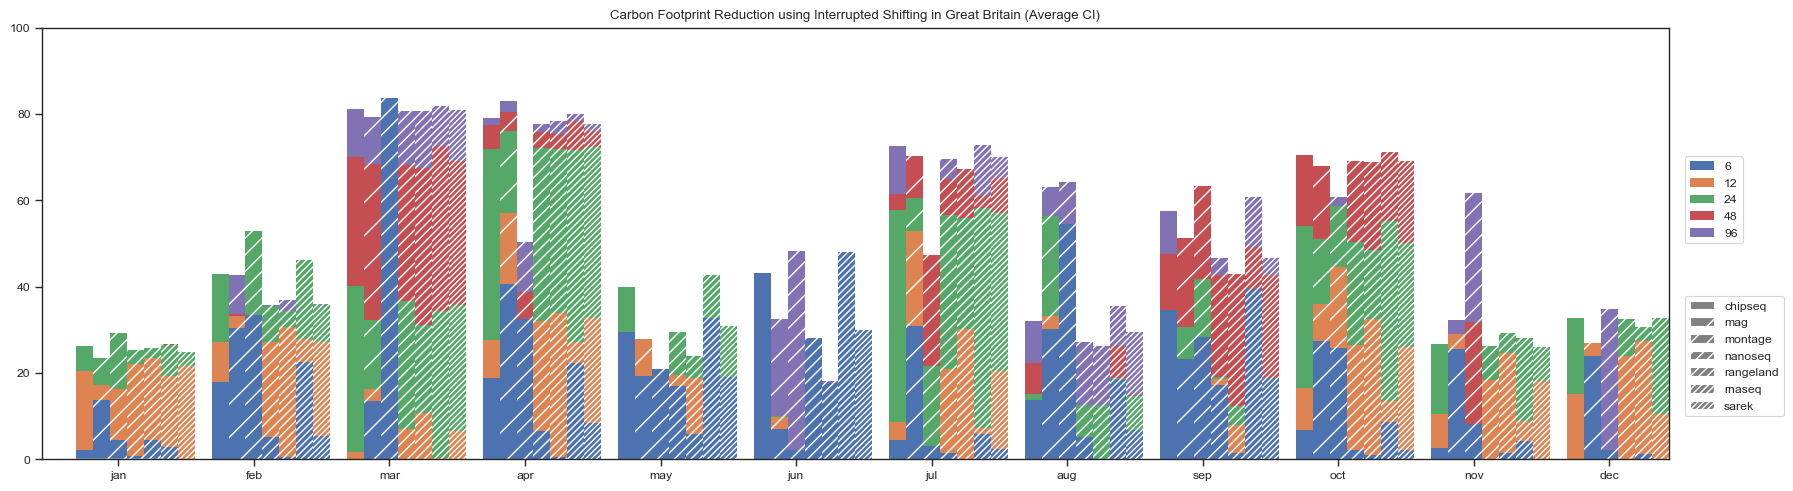

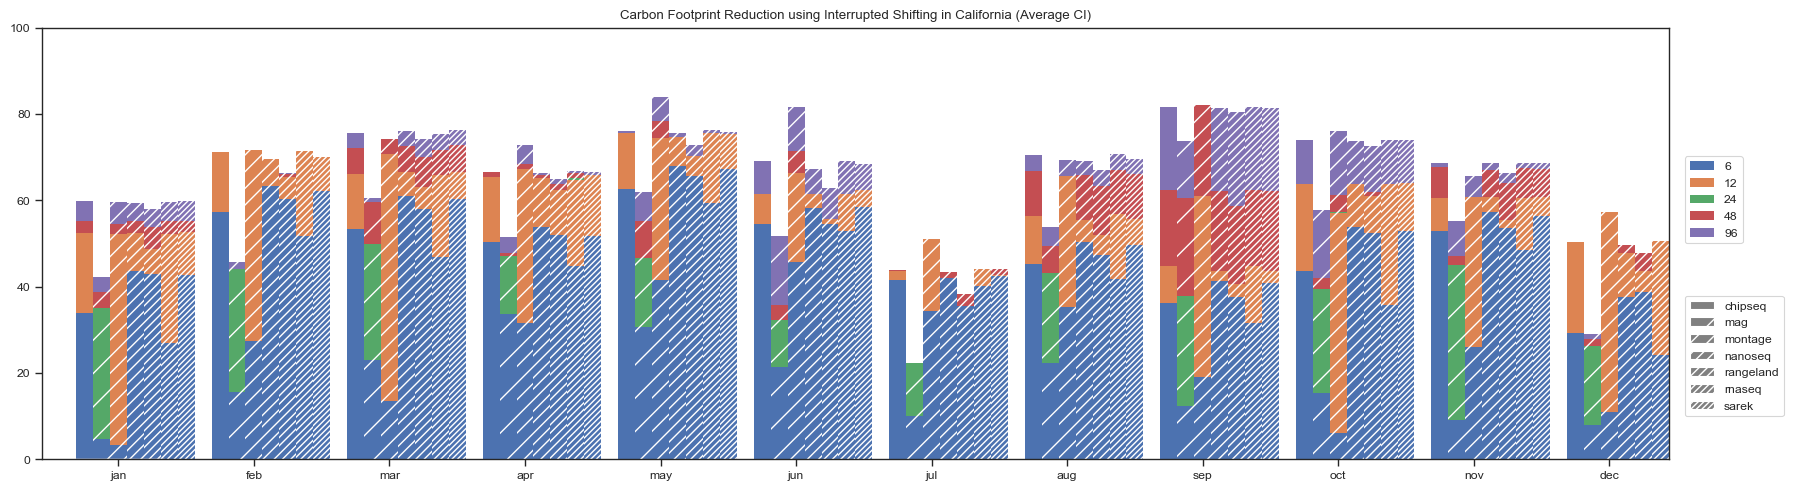

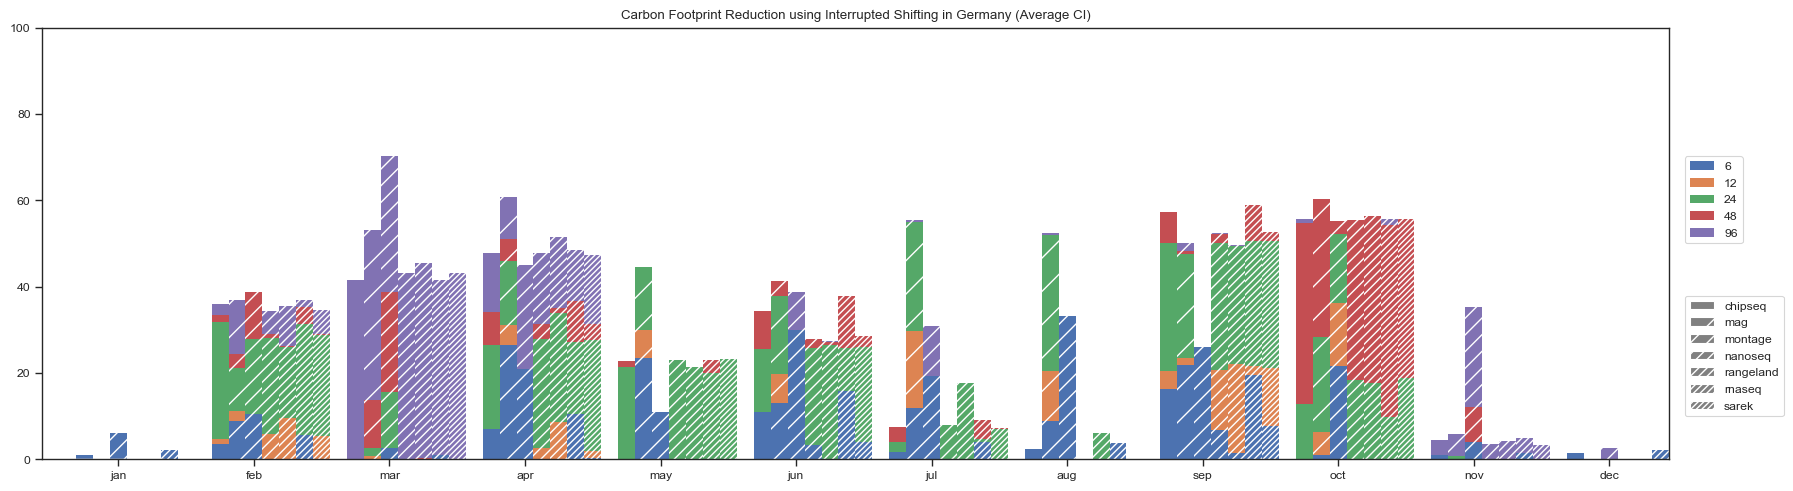

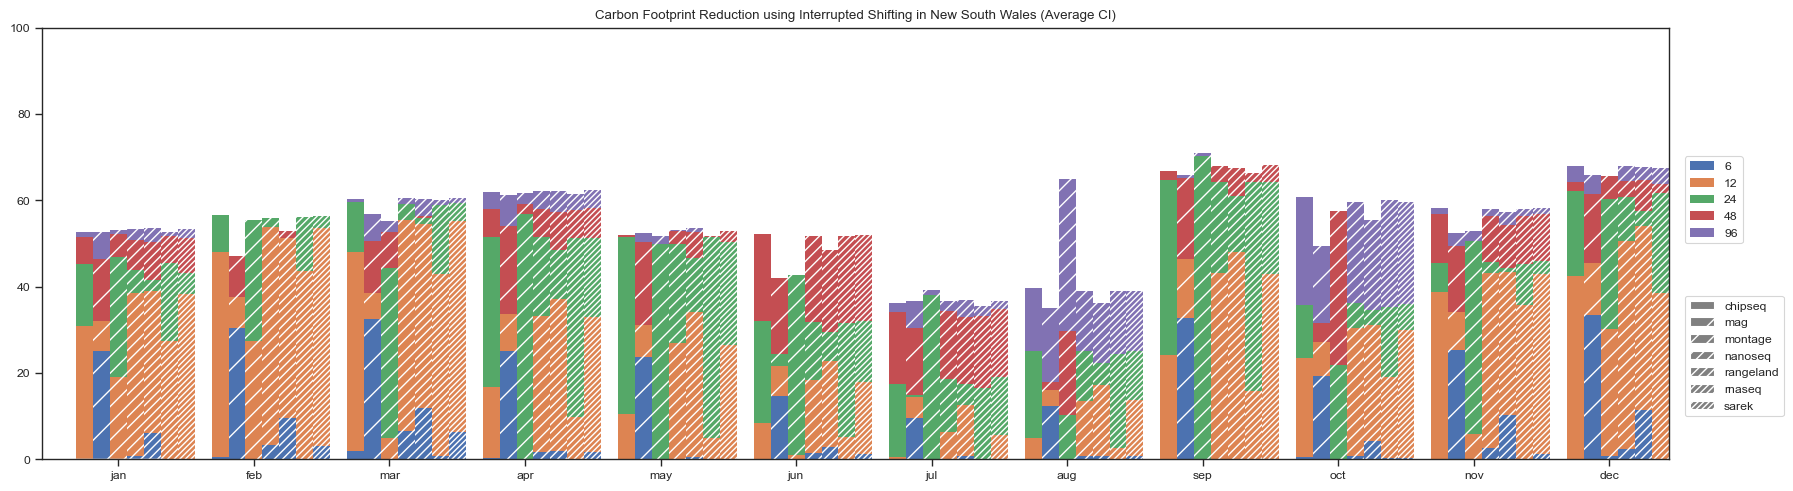

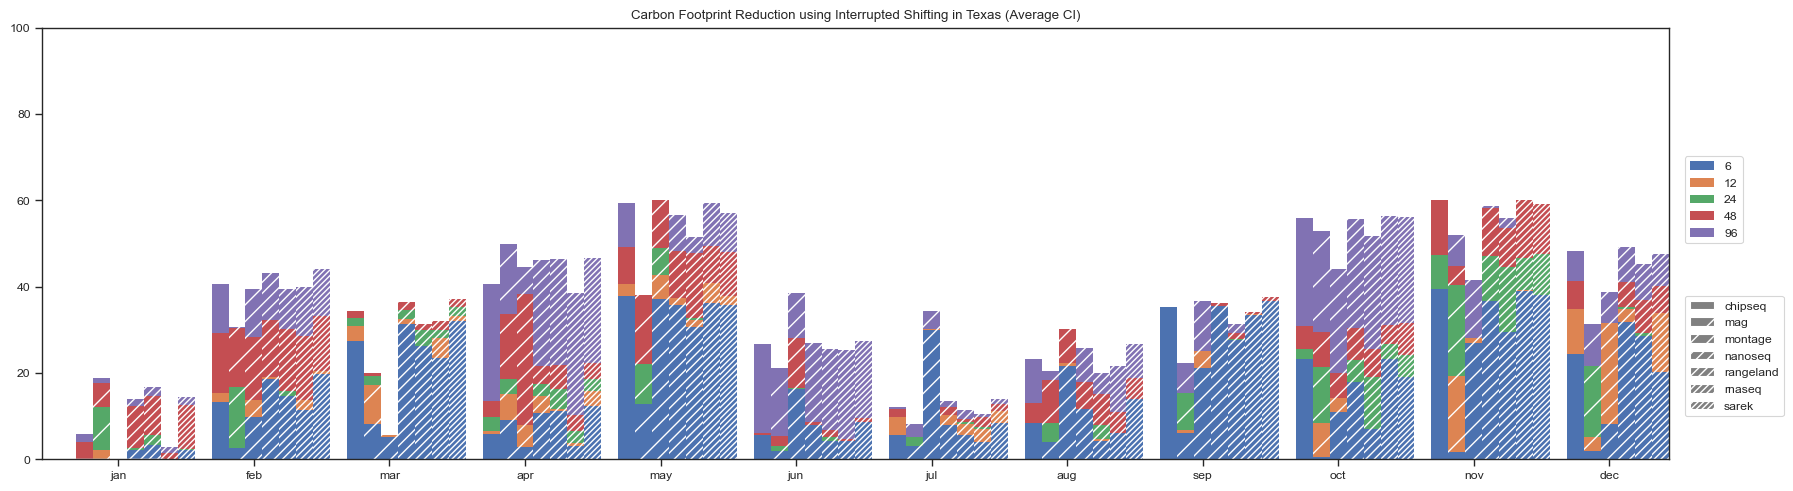

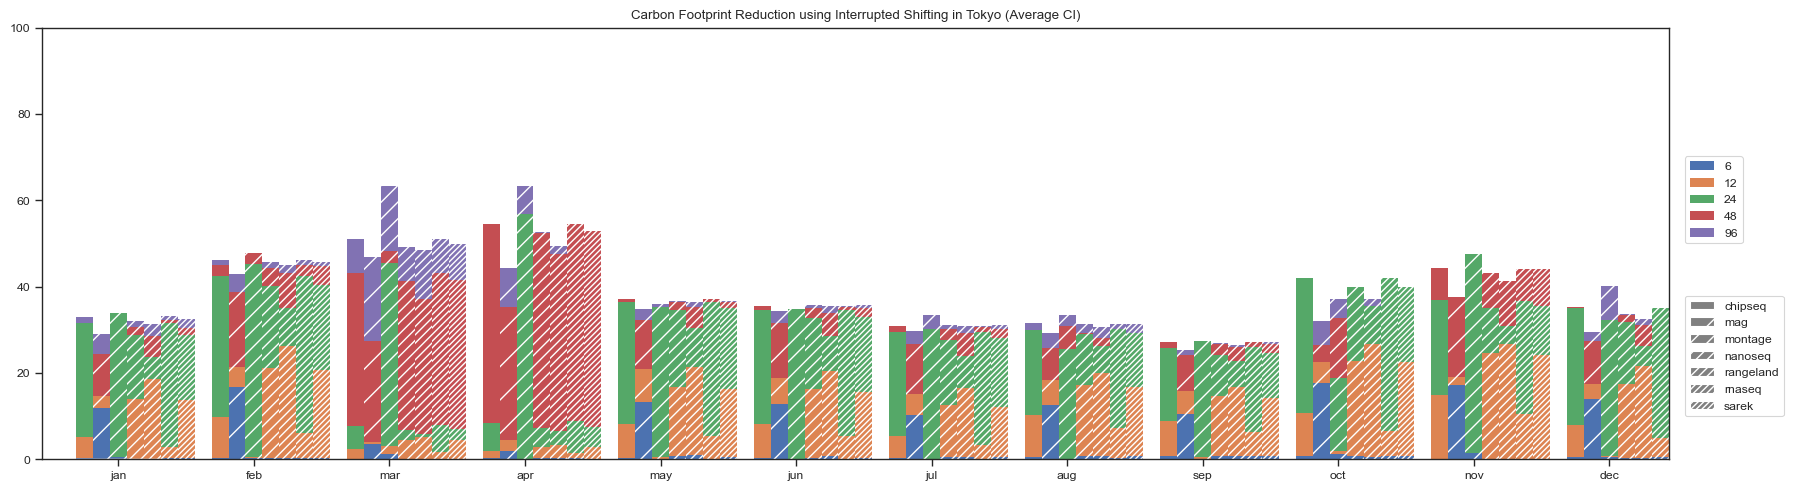

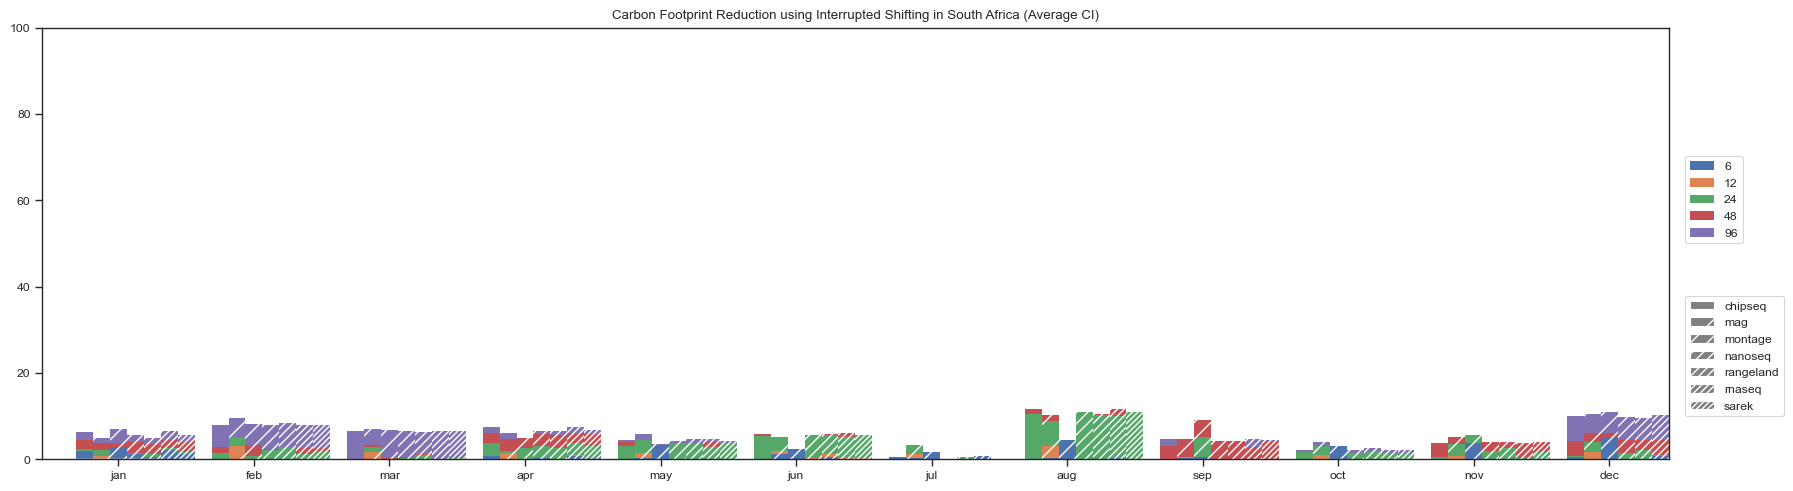

In [182]:
# Plot Average CI Results
plot_int_shift_for_region('gb', wf_data_by_region_avg, True, title='Carbon Footprint Reduction using Interrupted Shifting in Great Britain (Average CI)')
plot_int_shift_for_region('ca', wf_data_by_region_avg, True, title='Carbon Footprint Reduction using Interrupted Shifting in California (Average CI)')
plot_int_shift_for_region('de', wf_data_by_region_avg, True, title='Carbon Footprint Reduction using Interrupted Shifting in Germany (Average CI)')
plot_int_shift_for_region('nsw', wf_data_by_region_avg, True, title='Carbon Footprint Reduction using Interrupted Shifting in New South Wales (Average CI)')
plot_int_shift_for_region('tx', wf_data_by_region_avg, True, title='Carbon Footprint Reduction using Interrupted Shifting in Texas (Average CI)')
plot_int_shift_for_region('tyo', wf_data_by_region_avg, True, title='Carbon Footprint Reduction using Interrupted Shifting in Tokyo (Average CI)')
plot_int_shift_for_region('zaf', wf_data_by_region_avg, True, title='Carbon Footprint Reduction using Interrupted Shifting in South Africa (Average CI)')

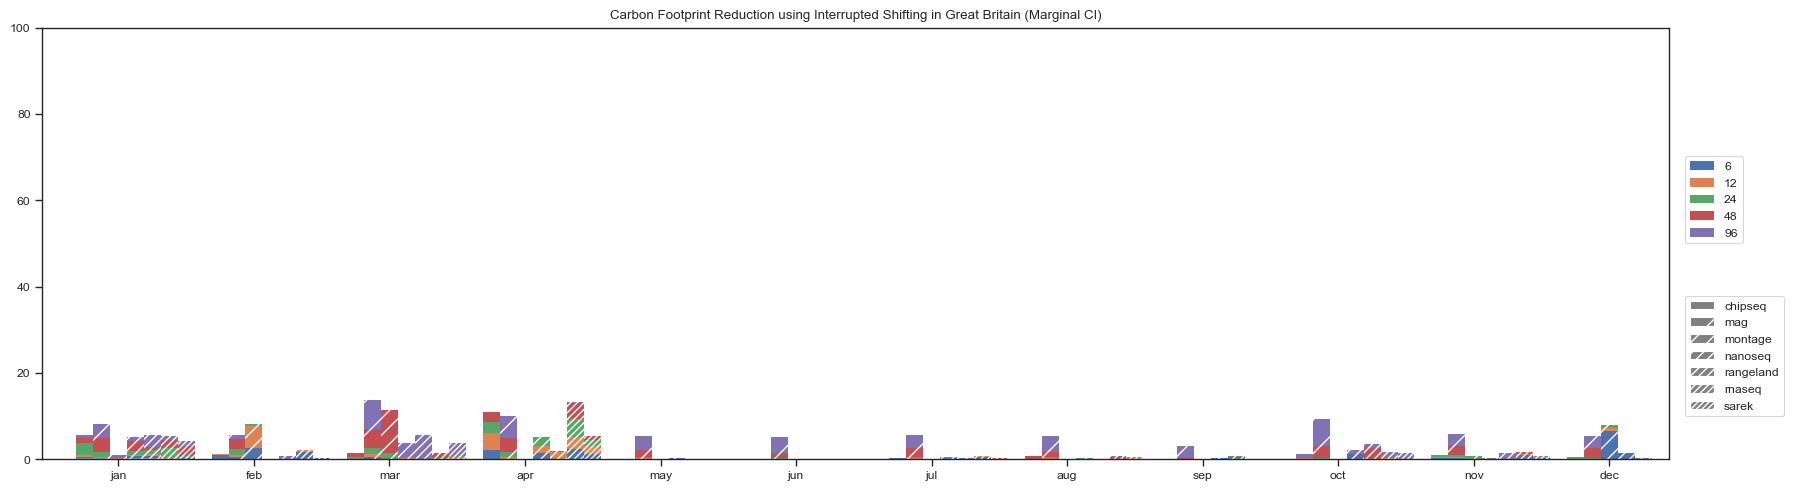

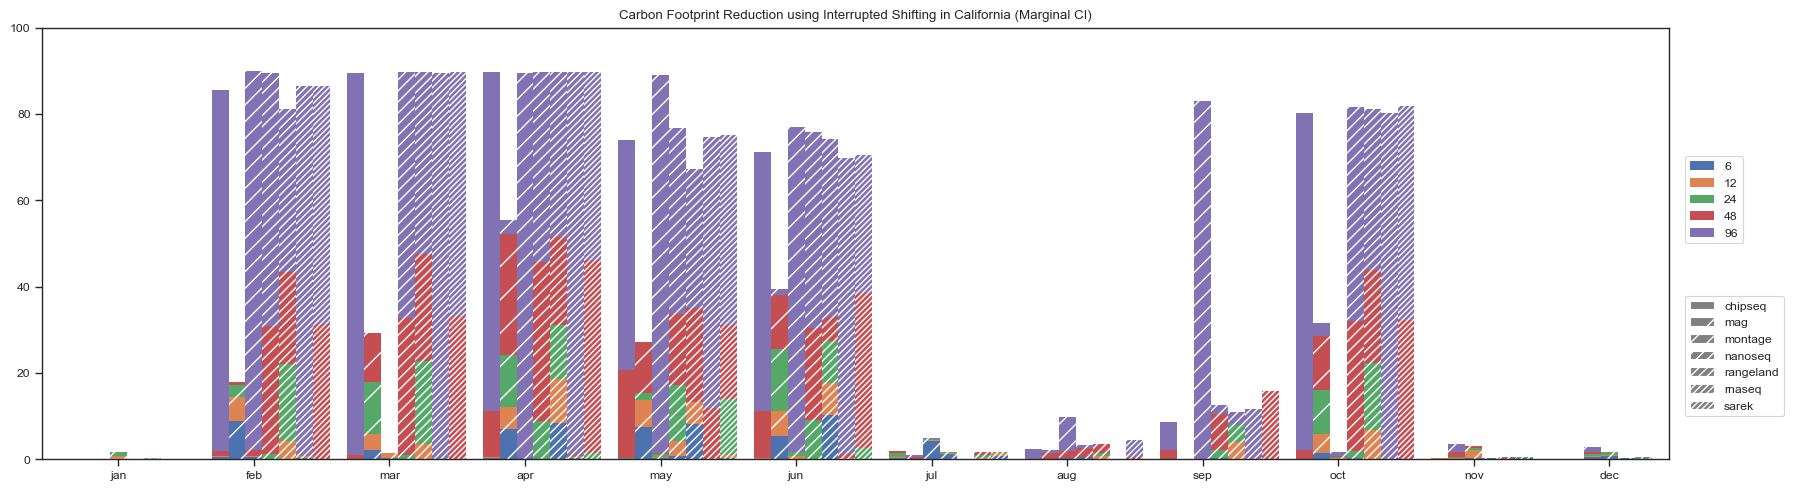

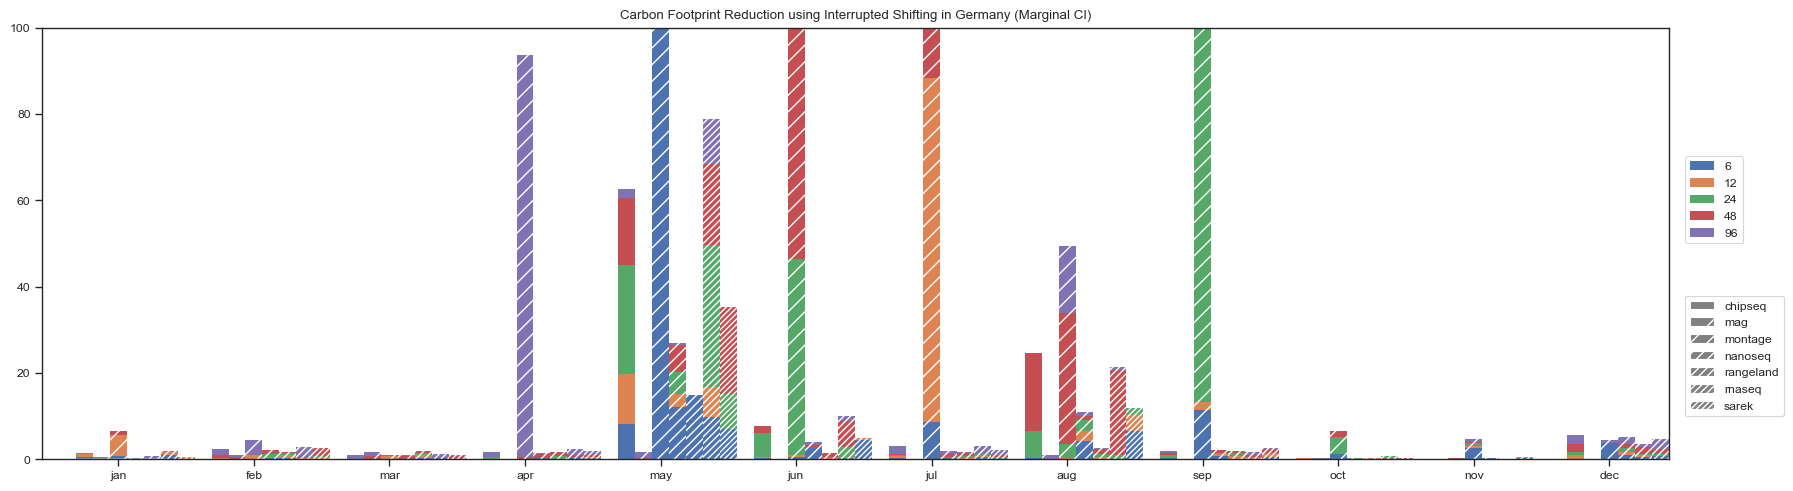

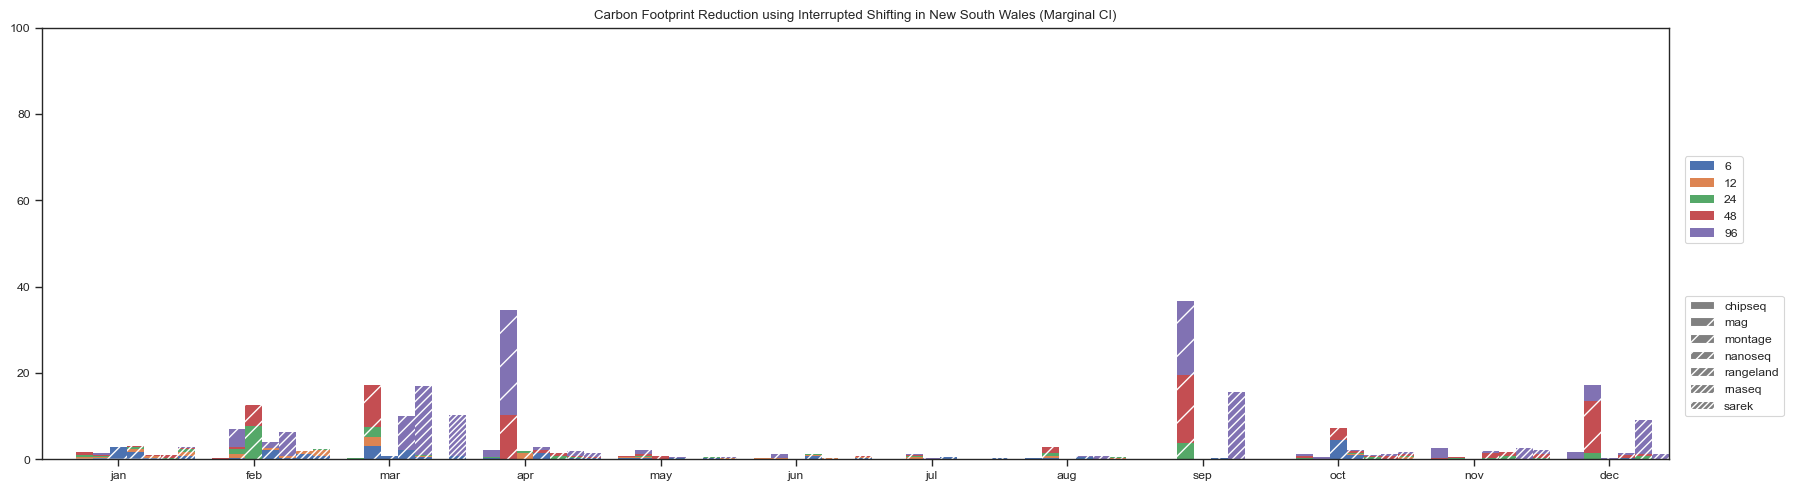

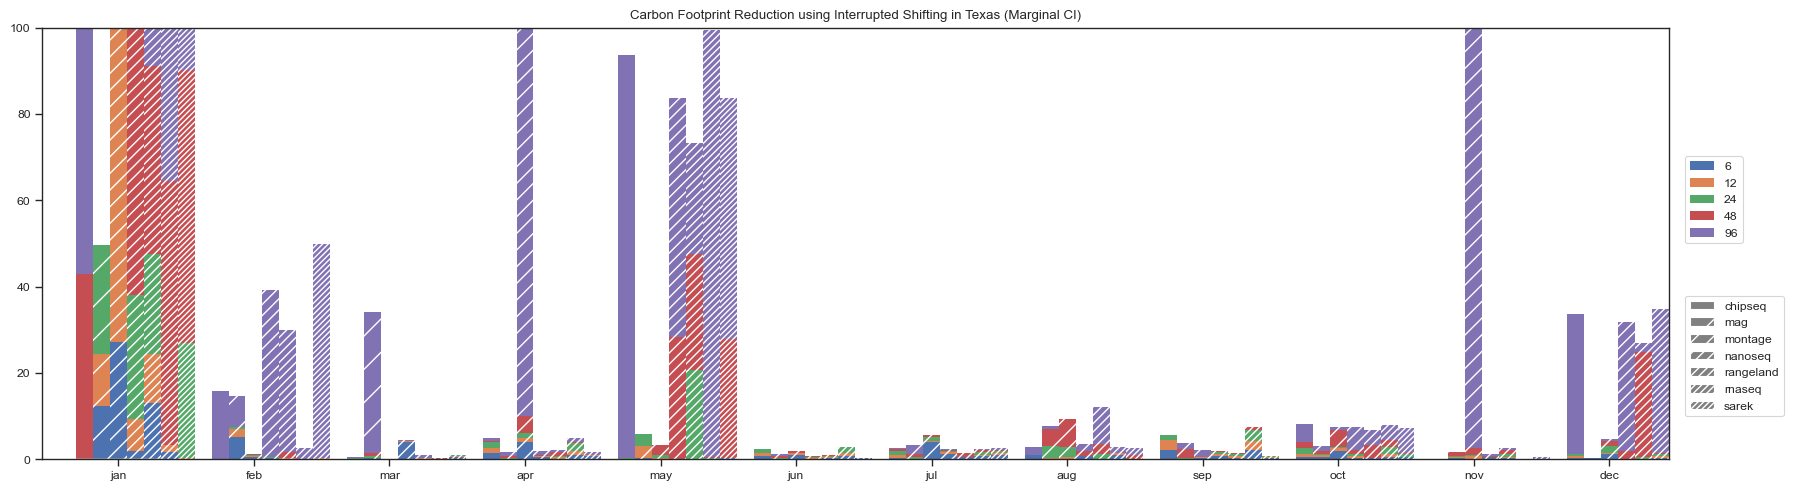

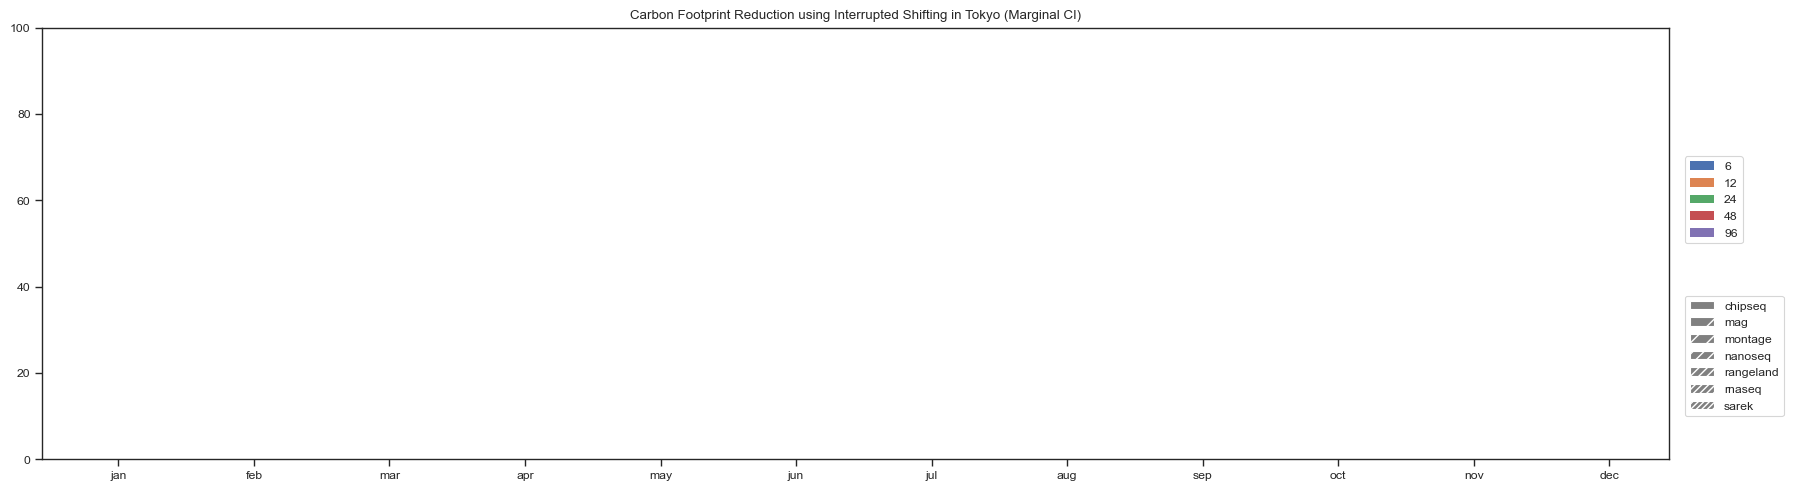

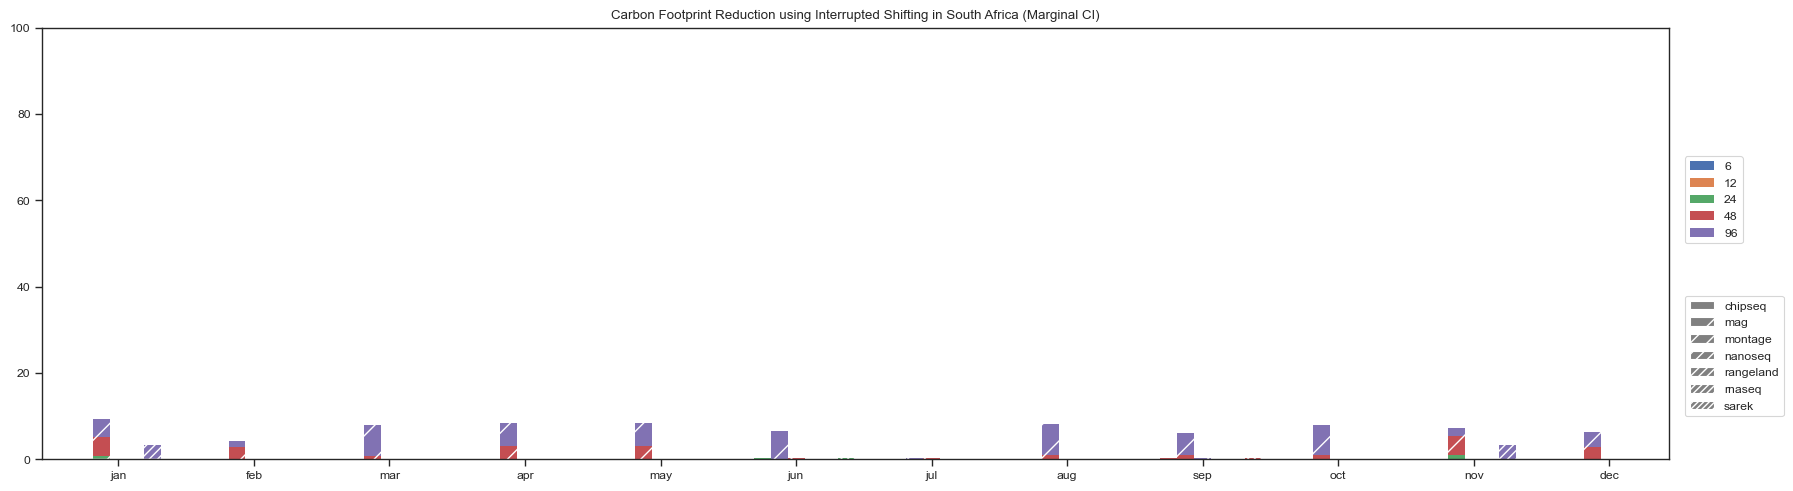

In [181]:
# Plot Marginal CI Results
plot_int_shift_for_region('gb', wf_data_by_region_marg, False, title='Carbon Footprint Reduction using Interrupted Shifting in Great Britain (Marginal CI)')
plot_int_shift_for_region('ca', wf_data_by_region_marg, False, title='Carbon Footprint Reduction using Interrupted Shifting in California (Marginal CI)')
plot_int_shift_for_region('de', wf_data_by_region_marg, False, title='Carbon Footprint Reduction using Interrupted Shifting in Germany (Marginal CI)')
plot_int_shift_for_region('nsw', wf_data_by_region_marg, False, title='Carbon Footprint Reduction using Interrupted Shifting in New South Wales (Marginal CI)')
plot_int_shift_for_region('tx', wf_data_by_region_marg, False, title='Carbon Footprint Reduction using Interrupted Shifting in Texas (Marginal CI)')
plot_int_shift_for_region('tyo', wf_data_by_region_marg, False, title='Carbon Footprint Reduction using Interrupted Shifting in Tokyo (Marginal CI)')
plot_int_shift_for_region('zaf', wf_data_by_region_marg, False, title='Carbon Footprint Reduction using Interrupted Shifting in South Africa (Marginal CI)')